In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
st = set(stopwords.words('english'))

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/NewUser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/NewUser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [180]:
# read in data
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')
#df_eng.drop_duplicates(inplace=True)

# basic cuts on targets
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 20].index]
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.5].index]

df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 20].index]

df_eng = df_eng.loc[df_eng[df_eng['hours_tutor'] <= 1000].index]

df_eng.reset_index(drop=True, inplace=True)
df_eng['bio_count'] = df_eng['bio'].apply(lambda x: len(str(x).split(" ")))

In [170]:
freq = pd.Series(' '.join(df_eng['bio']).split()).value_counts()[:20]
freq

and         26137
I           24956
to          18357
the         15731
a           15091
in          14823
of          11074
have         8419
my           7257
for          7005
with         6897
students     6050
as           5301
is           4455
that         4448
am           4112
at           3591
you          3450
math         3426
tutoring     3335
dtype: int64

In [181]:
%%time
#Create the corpus of bios

stop_words = set(stopwords.words("english"))
new_words = ["using", "show", "result", "large", "also", "one", "two", "new", "previously", "shown", 'math']
stop_words = stop_words.union(new_words)

corpus = []
for i in range(0, len(df_eng['bio'])):
    
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df_eng['bio'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # remove periods
    text = text.replace('.', '').replace(',' , '')
    
    #Convert to list from string
    text = text.split()
    
    ##Stemming
    stemmer=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    #text = [stemmer.stem(lem.lemmatize(word)) for word in text if not word in stop_words]
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    corpus.append(text)

CPU times: user 4.06 s, sys: 36.9 ms, total: 4.1 s
Wall time: 4.21 s


[Text(0, 0, 'student'),
 Text(0, 0, 'school'),
 Text(0, 0, 'tutoring'),
 Text(0, 0, 'year'),
 Text(0, 0, 'help'),
 Text(0, 0, 'teaching'),
 Text(0, 0, 'college'),
 Text(0, 0, 'experience'),
 Text(0, 0, 'high'),
 Text(0, 0, 'tutor'),
 Text(0, 0, 'science'),
 Text(0, 0, 'subject'),
 Text(0, 0, 'algebra'),
 Text(0, 0, 'university'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'mathematics'),
 Text(0, 0, 'level'),
 Text(0, 0, 'work'),
 Text(0, 0, 'calculus'),
 Text(0, 0, 'physic')]

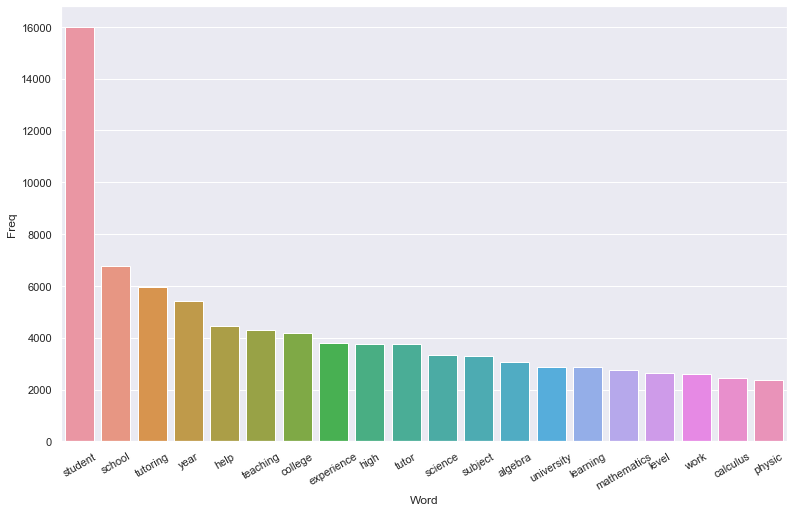

In [6]:
#Most frequently occuring words

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'high school'),
 Text(0, 0, 'help student'),
 Text(0, 0, 'middle school'),
 Text(0, 0, 'year experience'),
 Text(0, 0, 'helping student'),
 Text(0, 0, 'look forward'),
 Text(0, 0, 'school student'),
 Text(0, 0, 'school college'),
 Text(0, 0, 'sat act'),
 Text(0, 0, 'experience tutoring'),
 Text(0, 0, 'algebra geometry'),
 Text(0, 0, 'college level'),
 Text(0, 0, 'algebra algebra'),
 Text(0, 0, 'master degree'),
 Text(0, 0, 'tutoring experience'),
 Text(0, 0, 'computer science'),
 Text(0, 0, 'working student'),
 Text(0, 0, 'college student'),
 Text(0, 0, 'feel free'),
 Text(0, 0, 'pre algebra')]

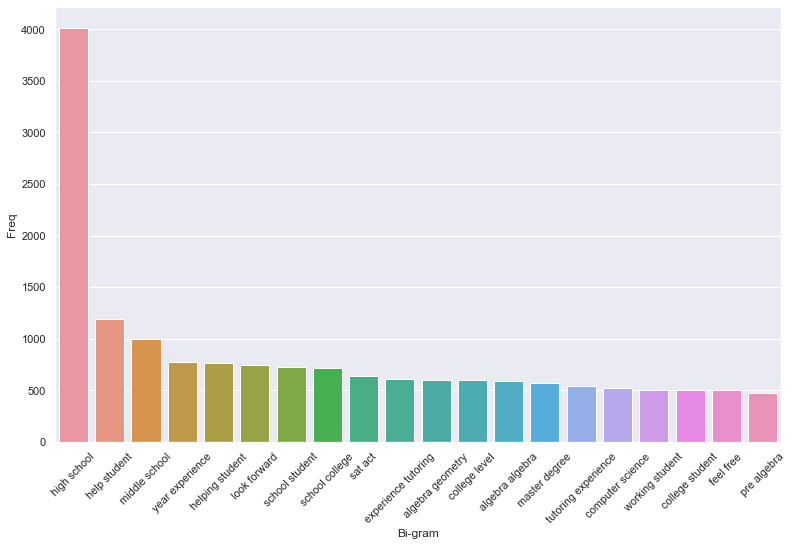

In [159]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

[Text(0, 0, 'high school college'),
 Text(0, 0, 'high school student'),
 Text(0, 0, 'feel free contact'),
 Text(0, 0, 'school high school'),
 Text(0, 0, 'pre algebra algebra'),
 Text(0, 0, 'middle school high'),
 Text(0, 0, 'middle high school'),
 Text(0, 0, 'please feel free'),
 Text(0, 0, 'year experience tutoring'),
 Text(0, 0, 'look forward working'),
 Text(0, 0, 'high school level'),
 Text(0, 0, 'look forward hearing'),
 Text(0, 0, 'school college level'),
 Text(0, 0, 'algebra geometry trigonometry'),
 Text(0, 0, 'school college student'),
 Text(0, 0, 'year experience teaching'),
 Text(0, 0, 'year tutoring experience'),
 Text(0, 0, 'algebra algebra geometry'),
 Text(0, 0, 'pre calculus calculus'),
 Text(0, 0, 'free contact question')]

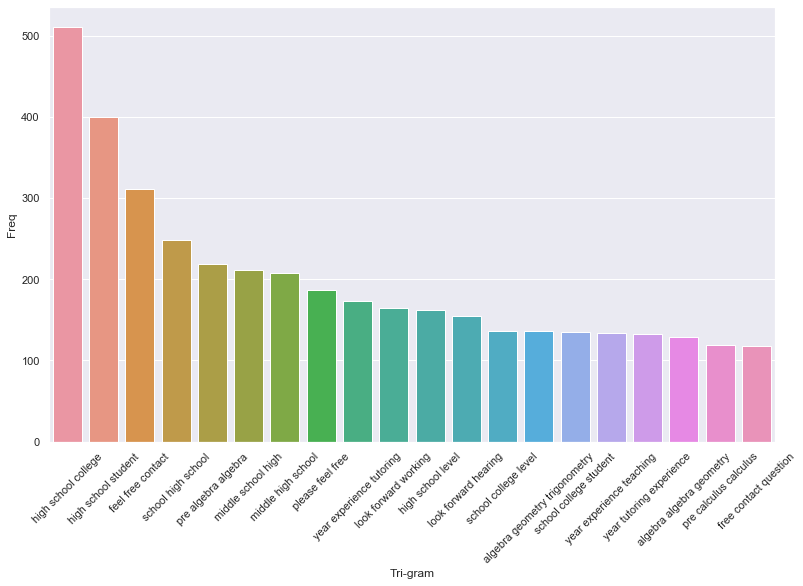

In [8]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [182]:
%%time
df_nlp = pd.DataFrame()
for i in range(4):
    vectorizer = TfidfVectorizer(ngram_range=(i,i), max_features=200)
    vectors = vectorizer.fit(corpus)
    vectors = vectors.transform(corpus)

    names = vectorizer.get_feature_names()
    data = vectors.todense().tolist()
    # Create a dataframe with the results
    temp_df = pd.DataFrame(data, columns=names)
    df_nlp = pd.concat([df_nlp, temp_df], axis=1)

CPU times: user 6.37 s, sys: 193 ms, total: 6.56 s
Wall time: 6.66 s


In [105]:
potential_list

['contact',
 'contact question',
 'experience',
 'enjoy',
 'help',
 'helping',
 'love',
 'success',
 'understand',
 'understanding',
 'every student',
 'experience teaching',
 'experience tutoring',
 'experience working',
 'feel free',
 'forward working',
 'free contact',
 'full time',
 'hello name',
 'help student',
 'helped student',
 'helping others',
 'helping student',
 'hi name',
 'look forward',
 'love help',
 'love teaching',
 'make sure',
 'many student',
 'many year',
 'need help',
 'please contact',
 'please feel',
 'solve problem',
 'student learn',
 'student learning',
 'student need',
 'student understand',
 'teaching experience',
 'teaching style',
 'teaching tutoring',
 'tutoring experience',
 'work student',
 'worked student',
 'working student',
 'would like',
 'would love',
 'year experience',
 'year teaching',
 'year tutoringachieve academic goal',
 'believe every student',
 'enjoy helping student',
 'enjoy working student',
 'experience teaching tutoring',
 'experi

In [183]:
experience_list = ['experience teaching tutoring', 'experience tutoring student', 'experience working student', 
                   'many student', 'many year', 
                   'year experience teaching', 'year experience tutoring',
                   'year experience working',
                   'year teaching experience', 'year tutoring experience']
                   
welcoming_list = ['look forward hearing', 'look forward helping', 'look forward meeting', 'look forward working',
                  'forward working', 'hello name', 'hi name', 'please contact', 'please feel',
                  'would like', 'would love', 'feel free contact', 'feel free reach', 'free contact question']
                  
goal_list = ['goal help student', 'achieve academic goal',  
             'help student succeed', 'helping student achieve']

passion_list = ['enjoy helping student', 'enjoy working student', 'look forward', 
                 'believe every student', 'love help', 'love teaching', 
                 'love helping student', 'love working student', 'would love help']

In [190]:
def normalize(df):
    return (df - df.min()) / (df.max()-df.min())

df_eng['experience_kw'] = df_nlp[experience_list].sum(axis=1)
df_eng['welcoming_kw'] = df_nlp[welcoming_list].sum(axis=1)
df_eng['goal_kw'] = df_nlp[goal_list].sum(axis=1)
df_eng['passion_kw'] = df_nlp[passion_list].sum(axis=1)

In [194]:
top_tutors = [np.array(df_eng.sort_values('hours_per_week_estimate', ascending=False)['experience_kw'].head(500)).mean(),
                np.array(df_eng.sort_values('hours_per_week_estimate', ascending=False)['welcoming_kw'].head(500)).mean(),
                np.array(df_eng.sort_values('hours_per_week_estimate', ascending=False)['passion_kw'].head(500)).mean(),
                np.array(df_eng.sort_values('hours_per_week_estimate', ascending=False)['bio_count'].head(500)).mean()] 
top_tutors

[0.12294611524275881, 0.23945995025273265, 0.1208662082977176, 259.226]

In [195]:
df_nlp_category = df_eng[['experience_kw','welcoming_kw', 'passion_kw']]
df_nlp_category.to_csv('tutor_nlp.csv', index=False)
df_nlp_category.describe()

,experience_kw,welcoming_kw,passion_kw
count,2492.000000,2492.000000,2492.000000
mean,0.128492,0.223684,0.121368
std,0.265364,0.350826,0.239519
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.162672,0.370863,0.191155
max,1.633420,1.847217,1.825962
